In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Redes Neurais: Séries Temporais

Autor: Arthur Schneider Figueira

## Lendo as bibliotecas

In [2]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Databases/AC3/acoes_train.csv', index_col='index')
train.tail()

,Date,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag
index,,,,,,,,,,,
1450,1/4/2021 16:00:00,222.53,223.00,214.81,217.69,37130139,222.42,221.68,224.15,224.96,222.75
1451,1/5/2021 16:00:00,217.26,218.52,215.70,217.90,23822953,217.69,222.42,221.68,224.15,224.96
1452,1/6/2021 16:00:00,212.17,216.49,211.94,212.25,35930653,217.90,217.69,222.42,221.68,224.15
1453,1/7/2021 16:00:00,214.04,219.34,213.71,218.29,27694480,212.25,217.90,217.69,222.42,221.68
1454,1/8/2021 16:00:00,218.68,220.58,217.03,219.62,22956206,218.29,212.25,217.90,217.69,222.42


In [5]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science/Databases/AC3/acoes_test.csv', index_col='index')
test.tail()

,Date,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag
index,,,,,,,,,,,
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853,235.46,237.58,235.99,230.35,230.72
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853,232.34,235.46,237.58,235.99,230.35
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455,236.48,232.34,235.46,237.58,235.99
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012,235.24,236.48,232.34,235.46,237.58
1510,3/31/2021 16:00:00,232.91,239.10,232.39,235.77,43623471,231.85,235.24,236.48,232.34,235.46


### Rede Neural LSTM

A arquitetura LSTM de rede neural funciona a partir das unidades. Cada unidade é como se fosse um neurônio que é conectado ao outro de maneira sequencial:

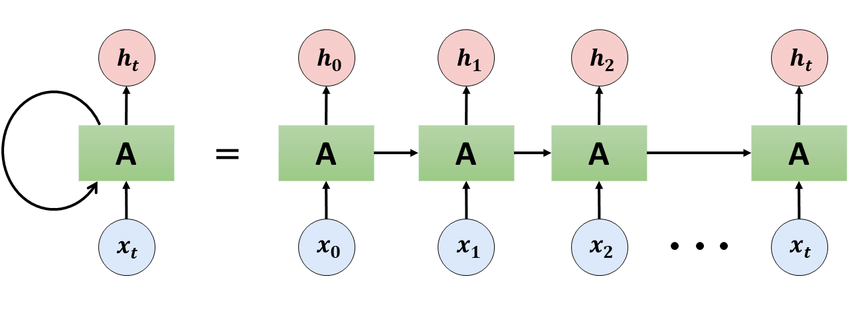

No exemplo acima, a gente compreende o motivo dessa rede ser Recorrente. Ou seja, o primeiro neurônio recebe uma entrada e gera uma saída. Essa saída é utilizada pelo neurônio seguinte, ao longo do tempo.

A arquitetura LSTM usa esse princípio combinando com particularidades extra:

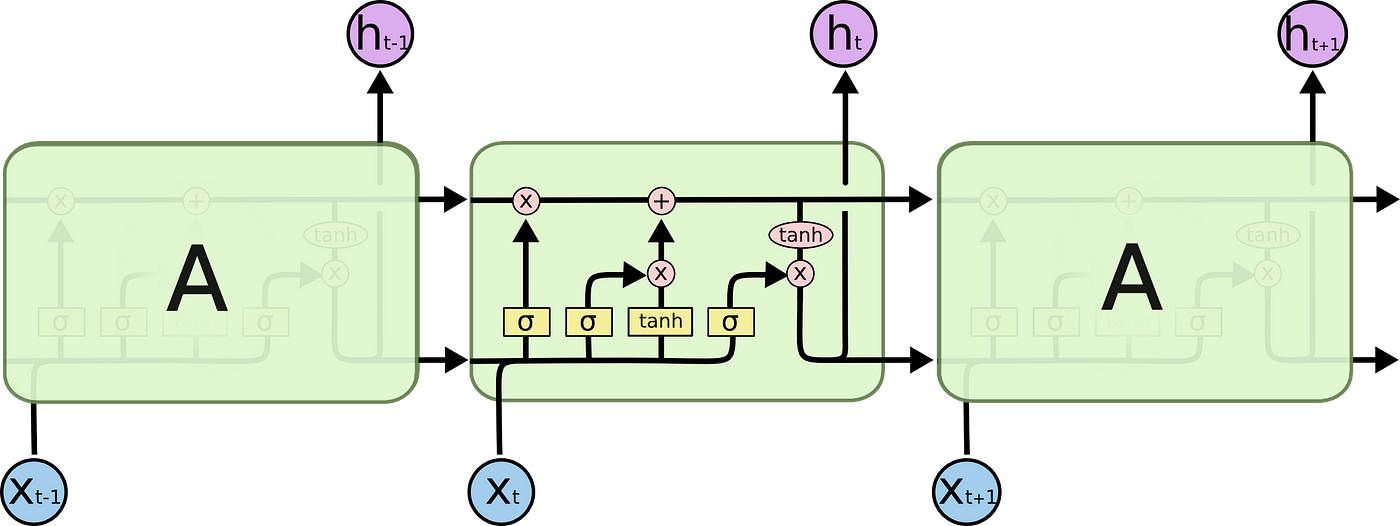

Na imagem acima, temos o seguinte exemplo:

O "X" do tempo anterior (t-1) é a entrada da unidade. Há a arquitetura da rede neural LSTM que analisa a entrada e gera 3 saídas. h(t-1) e mais duas saídas. A saída h (t-1) é uma parte do conhecimento da rede neural que será descartada. Já as outras duas saídas representadas pelas setas, seguem conectadas a próxima unidade da rede neural que vai receber a variável X (t). Portanto, é importante notar que além de receber a variável X no momento posterior, esse neurônio/unidade recebe também a experiência obtida no momento anterior (t-1).

Se observarmos uma unidade isoladamente, fica claro o que é recebido, "esquecido" e passado para a próxima unidade:

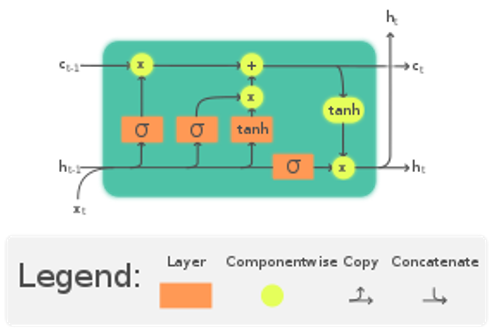

* Ct-1: é o output gerado pela unidade anterior e é aproveitado pela unidade atual;
* Ht-1: é o output gerado pela unidade anterior que é vinculado ao X atual e analisado pela unidade atual;
* H t: é o conhecimento gerado pela unidade. Uma parte dele é esquecido e outra parte é levada adiante;
* C t: é outro output gerado pela unidade LSTM que será utilizado na próxima unidade;
* A parte laranja são funções de ativação. Tangentes e sigmoids.
* A parte amarela envolve os vetores com valores e uma função de ativação tangente.

In [6]:
# Passo 1: separando X e Y e normalizando os dados

X = train[['Close_1lag',
           'Close_2lag',
           'Close_3lag',
           'Close_4lag',
           'Close_5lag']]

y = train["Close"]

# Normalização dos dados
# Normalize os dados (opcional, mas pode melhorar o desempenho da rede)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Converta os dados para o formato 3D esperado pela LSTM (samples, timesteps, features)
# Nesse caso, como temos apenas uma variável explicativa (3 features), definimos timesteps = 1.
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [7]:
len(X),len(y)

(1450, 1450)

In [8]:
X_lstm.shape #1462 linhas na base, por 1 data, com 3 variáveis explicativas em cada data

(1450, 1, 5)

### LSTM: Modelo 1

In [9]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model1.add(Dense(units=1))

# Passo 3: Compile o modelo

model1.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo
history1 = model1.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 1s 4ms/step - loss: 0.1478
Epoch 2/200
46/46 [==============================] - 0s 3ms/step - loss: 0.0289
Epoch 3/200
46/46 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 4/200
46/46 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 5/200
46/46 [==============================] - 0s 3ms/step - loss: 5.7553e-04
Epoch 6/200
46/46 [==============================] - 0s 3ms/step - loss: 3.9067e-04
Epoch 7/200
46/46 [==============================] - 0s 3ms/step - loss: 3.3586e-04
Epoch 8/200
46/46 [==============================] - 0s 4ms/step - loss: 3.1541e-04
Epoch 9/200
46/46 [==============================] - 0s 3ms/step - loss: 3.0542e-04
Epoch 10/200
46/46 [==============================] - 0s 2ms/step - loss: 2.9689e-04
Epoch 11/200
46/46 [==============================] - 0s 4ms/step - loss: 2.8836e-04
Epoch 12/200
46/46 [==============================] - 0s 3ms/step - loss: 2.7946e-04
Epoch

### LSTM: Modelo 2

In [10]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model2 = Sequential()
model2.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model2.add(Dense(units=1))

# Passo 3: Compile o modelo

model2.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history2 = model2.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 1s 2ms/step - loss: 0.0825
Epoch 2/200
46/46 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 3/200
46/46 [==============================] - 0s 2ms/step - loss: 5.4875e-04
Epoch 4/200
46/46 [==============================] - 0s 2ms/step - loss: 2.4292e-04
Epoch 5/200
46/46 [==============================] - 0s 2ms/step - loss: 2.3105e-04
Epoch 6/200
46/46 [==============================] - 0s 2ms/step - loss: 2.2952e-04
Epoch 7/200
46/46 [==============================] - 0s 3ms/step - loss: 2.2772e-04
Epoch 8/200
46/46 [==============================] - 0s 2ms/step - loss: 2.2486e-04
Epoch 9/200
46/46 [==============================] - 0s 2ms/step - loss: 2.2200e-04
Epoch 10/200
46/46 [==============================] - 0s 2ms/step - loss: 2.2668e-04
Epoch 11/200
46/46 [==============================] - 0s 2ms/step - loss: 2.2371e-04
Epoch 12/200
46/46 [==============================] - 0s 2ms/step - loss: 2.2572e-

### LSTM: Modelo 3

In [11]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model3 = Sequential()
model3.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model3.add(Dense(units=1))

# Passo 3: Compile o modelo

model3.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history3 = model3.fit(X_lstm, y_scaled, epochs=200, batch_size=128)

Epoch 1/200
12/12 [==============================] - 1s 3ms/step - loss: 0.1340
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0862
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0426
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 6/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 7/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 8/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 10/200
12/12 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 11/200
12/12 [==============================] - 0s 3ms/step - loss: 8.9559e-04
Epoch 12/200
12/12 [==============================] - 0s 3ms/step - loss: 7.2233e-04
Epoch 13/200
12/12 [=========

### Comparando a Loss

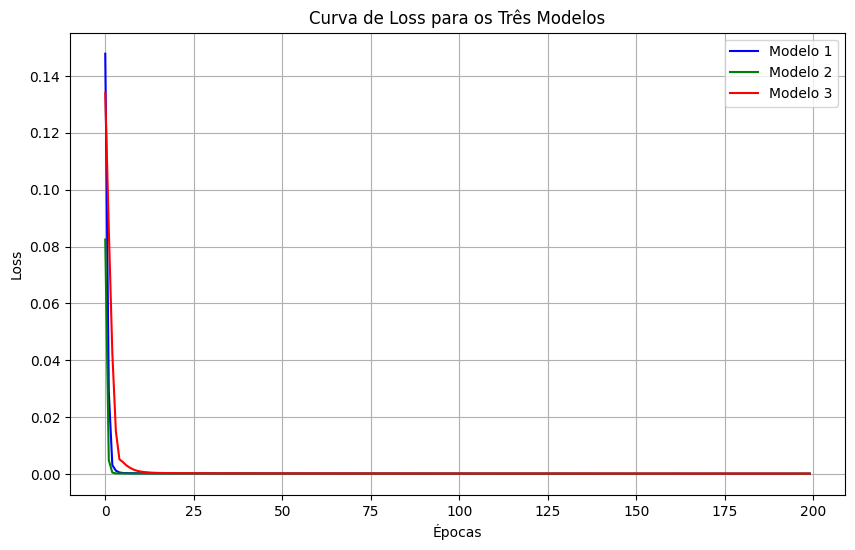

In [12]:
# Supondo que você tenha os objetos "history1", "history2" e "history3", que contêm informações sobre o treinamento dos três modelos.

# Plotando as curvas de loss
plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'], label='Modelo 1', color='blue')
plt.plot(history2.history['loss'], label='Modelo 2', color='green')
plt.plot(history3.history['loss'], label='Modelo 3', color='red')

plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss para os Três Modelos')
plt.legend()
plt.grid(True)
plt.show()

### Avaliando a base de teste

In [13]:
# Passo 1: Pré-processamento dos novos dados de teste

# Divida os dados em variáveis de entrada (X) e variável de saída (y), similar ao que você fez para os dados de treinamento.
X_test = test[['Close_1lag',
               'Close_2lag',
               'Close_3lag',
               'Close_4lag',
               'Close_5lag']]

# Normalize os dados usando o mesmo scaler que você usou para os dados de treinamento.
X_test_scaled = scaler_X.transform(X_test)

# Converta os dados para o formato 3D esperado pela LSTM
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Passo 2: Fazer previsões com o modelo LSTM

# Use o método predict para fazer as previsões
y_pred_scaled1 = model1.predict(X_test_lstm)
y_pred_scaled2 = model2.predict(X_test_lstm)
y_pred_scaled3 = model3.predict(X_test_lstm)

# Como o modelo retorna as previsões em escala, desfaça a normalização para obter as previsões reais
y_pred1 = scaler_y.inverse_transform(y_pred_scaled1)
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2)
y_pred3 = scaler_y.inverse_transform(y_pred_scaled3)

2/2 [==============================] - 0s 7ms/step


In [14]:
# Calcule o RMSE para cada modelo
rmse_model1 = np.sqrt(np.mean((np.array(test['Close']) - y_pred1) ** 2))
rmse_model2 = np.sqrt(np.mean((np.array(test['Close']) - y_pred2) ** 2))
rmse_model3 = np.sqrt(np.mean((np.array(test['Close']) - y_pred3) ** 2))

print('RMSE Modelo 1:', rmse_model1)
print('RMSE Modelo 2:', rmse_model2)
print('RMSE Modelo 3:', rmse_model3)

RMSE Modelo 1: 11.333228617411907
RMSE Modelo 2: 11.533830925241341
RMSE Modelo 3: 11.845094737652524


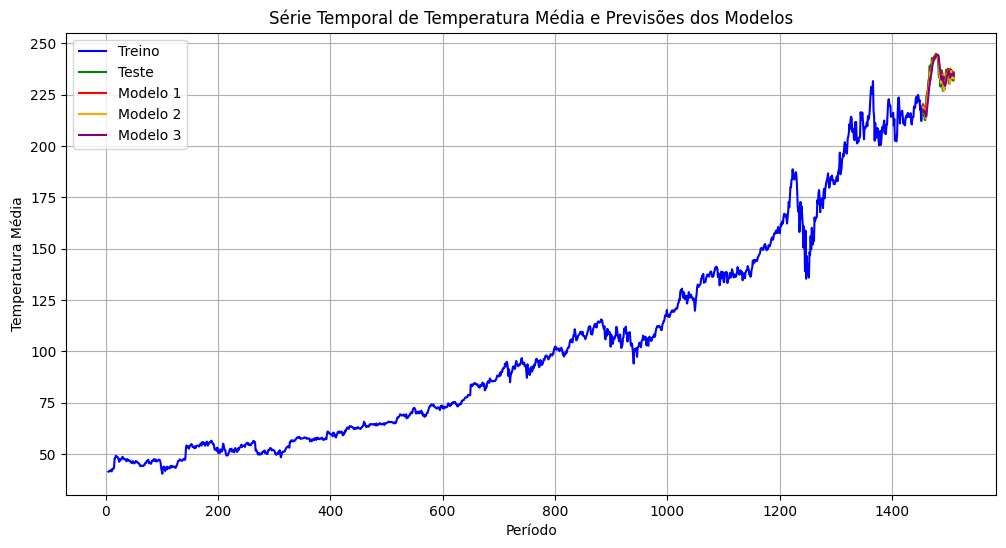

In [15]:
# Plotando a série temporal da coluna "Close" da base de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Treino', color='blue')
plt.plot(test.index, test['Close'], label='Teste', color='green')

# Plotando as previsões dos modelos em cores diferentes
plt.plot(test.index, y_pred1, label='Modelo 1', color='red')
plt.plot(test.index, y_pred2, label='Modelo 2', color='orange')
plt.plot(test.index, y_pred3, label='Modelo 3', color='purple')

plt.xlabel('Período')
plt.ylabel('Temperatura Média')
plt.title('Série Temporal de Temperatura Média e Previsões dos Modelos')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [16]:
test['Modelo 1'] = y_pred1
test['Modelo 2'] = y_pred2
test['Modelo 3'] = y_pred3

test

,Date,Open,High,Low,Close,Volume,Close_1lag,Close_2lag,Close_3lag,Close_4lag,Close_5lag,Modelo 1,Modelo 2,Modelo 3
index,,,,,,,,,,,,,,
1455,1/11/2021 16:00:00,218.47,218.91,216.73,217.49,23047029,219.62,218.29,212.25,217.90,217.69,220.422058,219.027786,217.363205
1456,1/12/2021 16:00:00,216.50,217.10,213.32,214.93,23249336,217.49,219.62,218.29,212.25,217.90,219.981339,218.758560,217.598618
1457,1/13/2021 16:00:00,214.02,216.76,213.93,216.34,20087080,214.93,217.49,219.62,218.29,212.25,218.172775,216.217163,216.542328
1458,1/14/2021 16:00:00,215.91,217.46,212.74,213.02,29346737,216.34,214.93,217.49,219.62,218.29,217.913956,216.164856,216.797928
1459,1/15/2021 16:00:00,213.52,214.51,212.03,212.65,31746512,213.02,216.34,214.93,217.49,219.62,216.295242,214.541153,215.664856
1460,1/19/2021 16:00:00,213.75,216.98,212.63,216.44,30480859,212.65,213.02,216.34,214.93,217.49,215.185394,213.447006,214.339233
1461,1/20/2021 16:00:00,217.70,225.79,217.29,224.34,37777260,216.44,212.65,213.02,216.34,214.93,217.011765,215.367508,214.526199
1462,1/21/2021 16:00:00,224.70,226.30,222.42,224.97,30749553,224.34,216.44,212.65,213.02,216.34,222.488144,221.595062,217.512070
1463,1/22/2021 16:00:00,227.08,230.07,225.80,225.95,30172663,224.97,224.34,216.44,212.65,213.02,225.622955,224.277496,220.078857


### AutoSarima

In [17]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00


In [18]:
import pmdarima as pm

In [19]:
# Crie o modelo AutoARIMA e encontre o melhor modelo ARIMA automaticamente
model4 = pm.auto_arima(np.array(train['Close']), exogenous=np.array(train[['Close_1lag', 'Close_2lag', 'Close_3lag', 'Close_4lag', 'Close_5lag']]), seasonal=True, m=7)  # O parâmetro "m" representa a frequência da sazonalidade (7 dias por semana)

# Faça as previsões usando o modelo treinado
y_pred4 = model4.predict(n_periods=len(np.array(test['Close'])), exogenous=np.array(test[['Close_1lag', 'Close_2lag', 'Close_3lag', 'Close_4lag', 'Close_5lag']]))

In [20]:
# Calcule o RMSE para avaliar o desempenho do modelo
rmse = mean_squared_error(np.array(test['Close']), y_pred4, squared=False)
print(f"RMSE do AutoARIMA: {rmse}")

RMSE do AutoARIMA: 12.885664180570883


# Conclusão

Percebemos que alterar a quantidade de unidades influencia no erro do modelo LSTM;

Ao comparar a rede neural LSTM com o modelo auto SARIMA, nesse exemplo, o LSTM superou o modelo SARIMA.

In [22]:
resultados = pd.DataFrame(index=test.index)

In [25]:
resultados['Modelo 1'] = y_pred1
resultados['Modelo 2'] = y_pred2
resultados['Modelo 3'] = y_pred3

In [26]:
resultados.to_csv('DAVID_ALMEIDA_MATHEUS_OLIVEIRA.csv')